# Copernicus Sentinel-5P TROPOMI - Ultraviolet Aerosol Index - Level 2

```{hint} 
<a href='https://fire.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/med_part2_workflows/figure4_Sentinel-5P_TROPOMI_UVAI.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

The Copernicus [Sentinel-5 Ultraviolet Visible Near-Infrared Shortwave (UVNS) spectrometer](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5) enables the measurement of trace gases which will improve air quality forecasts produced by the Copernicus Atmosphere Monitoring service.

This notebook provides you an introduction to data from [Sentinel-5P](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p), the precursor instrument and proxy for data from [Sentinel-5](https://www.eumetsat.int/sentinel-5). 

The event that this notebook hightlights are the fires in southern Italy and in Greece during August 2021.

For monitoring smoke, the `TROPOMI UV Aerosol Index (UVAI)` data can be used. Positive values of UVAI (typically > about 1.0) indicate the presence of absorbing-type aerosols: 
- `smoke from forest fires`, 
- `volcanic ash`, or 
- `desert dust`. 


```{admonition} Basic Facts
**Spatial resolution**: `Up to 5.5* km x 3.5 km` (5.5 km in the satellite flight direction and 3.5 km in the perpendicular direction at nadir) <br>
**Spatial coverage**: `Global` <br>
**Revisit time**:  `less than one day` <br>
**Data availability**: `since April 2018`
```

```{admonition} How to access the data
Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the <a href='https://dataspace.copernicus.eu/' target='_blank'>Copernicus Open Access Hub</a>. You need to register for an account before downloading data. 
```

<hr>

**Load required libraries**

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from netCDF4 import Dataset

# Python libraries for visualization
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.axes import Axes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

**Load helper functions**

In [2]:
%run ../functions.ipynb

<hr>

## Load and browse Sentinel-5P TROPOMI Aerosol Index Level 2 data

A Sentinel-5P TROPOMI UVAI Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load a netCDF file with the `open_dataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
* `group='PRODUCT'`: to load the `PRODUCT` group. 

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 5 August 2021 and inspect the data structure:

In [3]:
s5p = xr.open_dataset('../data/sentinel-5p/uvai/2021/08/05/S5P_OFFL_L2__AER_AI_20210805T110012_20210805T124141_19750_02_020200_20210807T004652.nc', group='PRODUCT')
s5p

<xarray.Dataset>
Dimensions:                          (scanline: 4172, ground_pixel: 450, time: 1, corner: 4)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.171e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2021-08-05
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 ...
    longitude                        (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (time, scanline) datetime64[ns] ...
    time_utc                         (time, scanline) object ...
    qa_value                         (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 ...

### Retrieve the Aerosol index from 340 and 380 nm

The Sentinel-5P TROPOMI aerosol index data provide the Aerosol Index for two different wavelength pairs: 
- `340_380 nm`
- `354_388 nm` 

For both parameters the interpretation of the index value is the same. 

Let us use the aerosol index for the wavelength pair 340_380 nm. The variable name is `aerosol_index_340_380`. You can select the variable from the data set, together with the geo-coordinates as follows:

In [4]:
uvai = s5p.aerosol_index_340_380[0,:,:]
lat = uvai.latitude
lon = uvai.longitude


<br>

### Read and apply the Quality Flag to the UVAI data

Another important parameter to read is the general quality flag called `qa_value`. The quality flag removes the sun glint pixels, where "falsely" high positive UVAI values over sea can be detected. In order to exclude sun glint, it is recommended to use only values where the `qa_value` is higher than 0.8. 

In [5]:
qa=s5p.qa_value[0,:,:]

<br>

The final step before plotting is to mask the aerosol index data based on the qa mask. You filter data with the `xarray` function `where`.

In [6]:
uvai_masked=uvai.where(qa > 0.8)

<br>

## Create  a geographical subset around Italy and Greece

You can zoom into a region by specifying a `bounding box` of interest. Let us set the extent to Italy and Greece with the following bounding box information:

In [7]:
lonmin=10
lonmax=30
latmin=35
latmax=45

You can use the function [](functions:generate_geographical_subset) to subset an `xarray.DataArray` based on a given bounding box.

In [8]:
s5p_uvai_subset = generate_geographical_subset(xarray=uvai_masked, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
s5p_uvai_subset

<xarray.DataArray 'aerosol_index_340_380' (scanline: 243, ground_pixel: 359)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.36e+03 2.361e+03 ... 2.601e+03 2.602e+03
  * ground_pixel  (ground_pixel) float64 77.0 78.0 79.0 ... 433.0 434.0 435.0
    time          datetime64[ns] 2021-08-05
    latitude      (scanline, ground_pixel) float32 32.12 32.14 ... 46.68 46.68
    longitude     (scanline, ground_pixel) float32 11.19 11.26 ... 29.7 29.8
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 380 and 340 nm
    long_name:               Aerosol index from 380 and 340 nm
    radiation_wavelength:    [340. 380.]
    ancillary_variables:     aerosol_index_340_380_precision

## Visualise the Sentinel-5P TROPOMI UV Aerosol Index values

For visualization, you can use the function [](functions:visualize_pcolormesh) to visualize the data. The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 380 and 340 nm 2021-08-05'}>)

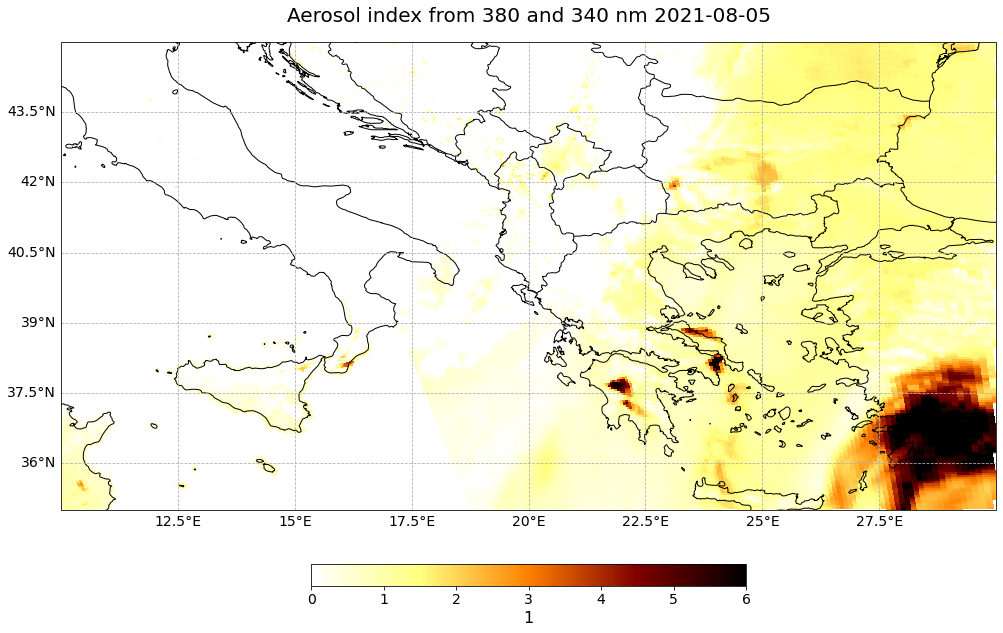

In [9]:
visualize_pcolormesh(data_array=s5p_uvai_subset,
                     longitude=s5p_uvai_subset.longitude, 
                     latitude=s5p_uvai_subset.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=uvai.units, 
                     long_name=uvai.long_name + ' ' + str(uvai.time.data)[0:10], 
                     vmin=0, 
                     vmax=6, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, 
                     set_global=False)


<hr>

### References
* Copernicus Sentinel data 2021

* Some code in this notebook was adapted from the following source:
    * origin: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/242_Sentinel-5P_TROPOMI_UVAI_L2_load_browse.ipynb
    * copyright: 2022, EUMETSAT
    * license: MIT
    * retrieved: 2022-06-28 by Sabrina Szeto

```{admonition} Return to the case study
Monitoring active fires with next-generation satellites: Mediterranean Fires Case Study <br>
[](med_part2_fig4)
```